In [ ]:
%%shell
pip install git+https://github.com/albumentations-team/albumentations.git

mkdir coco2017
cd coco2017


#wget http://images.cocodataset.org/zips/train2017.zip
wget http://images.cocodataset.org/zips/val2017.zip
#wget http://images.cocodataset.org/zips/test2017.zip
#wget http://images.cocodataset.org/zips/unlabeled2017.zip

#unzip train2017.zip
unzip val2017.zip
#unzip test2017.zip
#unzip unlabeled2017.zip

#rm train2017.zip
rm val2017.zip
#rm test2017.zip
#rm unlabeled2017.zip 

wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
wget http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip
#wget http://images.cocodataset.org/annotations/image_info_test2017.zip
#wget http://images.cocodataset.org/annotations/image_info_unlabeled2017.zip

unzip annotations_trainval2017.zip
unzip stuff_annotations_trainval2017.zip
#unzip image_info_test2017.zip
#unzip image_info_unlabeled2017.zip

rm annotations_trainval2017.zip
rm stuff_annotations_trainval2017.zip
#rm image_info_test2017.zip
#rm image_info_unlabeled2017.zip

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from coco import COCODataset
import torch


def show_processed(x, mode='train'):
  #trainset = COCODataset(data_dir='coco2017/', split='train2017', train=True)
  valset = COCODataset(data_dir='coco2017/', split='val2017', train=True, mode=mode)
  #train_dataloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=16, num_workers=2)
  val_dataloader  = torch.utils.data.DataLoader(valset, shuffle=False, batch_size=1, num_workers=2)
  tar = valset[x]
  img,boxes,masks = tar[0].permute(1,2,0), tar[1]['boxes'], tar[1]['masks']
  print('Image new size:',img.shape)

  fig, ax = plt.subplots(figsize=(8,8))
  ax.imshow(img)
  for i in boxes:
    rect = patches.Rectangle((i[0], i[1]), i[2]-i[0], i[3]-i[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
  masked = torch.zeros(img.shape[0], img.shape[1]).bool()
  for i in masks:
    masked += i.bool()
  ax.imshow(masked, alpha=0.3)

plt.show()

## Example Processed image (TRAIN)

- HorizontalFlip(p=0.5),
- RandomSizedBBoxSafeCrop(width=224, height=224, erosion_rate = 0.),
- RandomBrightnessContrast(p=0.2),
- ShiftScaleRotate(p=0.5, rotate_limit=15, shift_limit=0.0625, scale_limit=0.05),

loading annotations into memory...
Done (t=0.94s)
creating index...
index created!
Image new size: torch.Size([224, 224, 3])


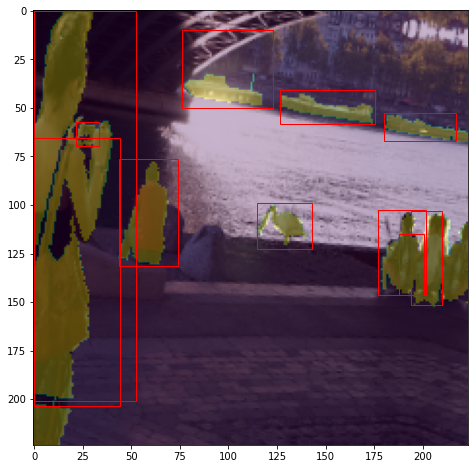

In [ ]:
x=10
show_processed(x=10, mode='train')

#Example Processed Image (VAL)

-  HorizontalFlip(p=0.5),
- RandomSizedBBoxSafeCrop(width=224, height=224, erosion_rate = 0.) 
- ToTensorV2()

loading annotations into memory...
Done (t=0.76s)
creating index...
index created!
Image new size: torch.Size([224, 224, 3])


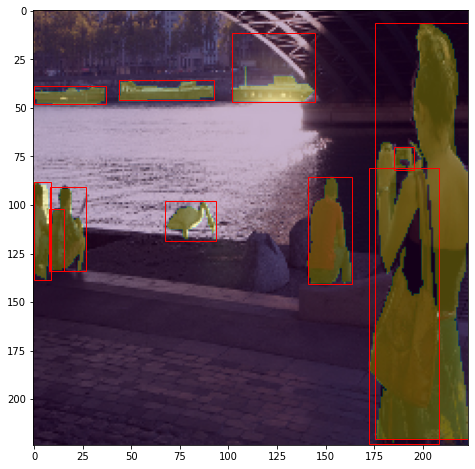

In [ ]:
x=10
show_processed(x=10, mode='val')

# Classes

In [ ]:
import os
from PIL import Image

import torch
from generalized_dataset import GeneralizedDataset

       
class COCODataset(GeneralizedDataset):
    def __init__(self, data_dir, split, train=False, mode = 'train'):
        super().__init__()
        from pycocotools.coco import COCO
        
        self.data_dir = data_dir
        self.split = split
        self.train = train
        self.mode = mode
        
        ann_file = os.path.join(data_dir, "annotations/instances_{}.json".format(split))
        self.coco = COCO(ann_file)
        self.ids = [str(k) for k in self.coco.imgs]
        
        # classes's values must start from 1, because 0 means background in the model
        self.classes = {k: v["name"] for k, v in self.coco.cats.items()}
        
        checked_id_file = os.path.join(data_dir, "checked_{}.txt".format(split))
        if train:
            if not os.path.exists(checked_id_file):
                self._aspect_ratios = [v["width"] / v["height"] for v in self.coco.imgs.values()]
            self.check_dataset(checked_id_file)
        
    def get_image(self, img_id):
        img_id = int(img_id)
        img_info = self.coco.imgs[img_id]
        image = Image.open(os.path.join(self.data_dir, "{}".format(self.split), img_info["file_name"]))
        return image.convert("RGB")
    
    @staticmethod
    def convert_to_xyxy(boxes): # box format: (xmin, ymin, w, h)
        x, y, w, h = boxes.T
        return torch.stack((x, y, x + w, y + h), dim=1) # new_box format: (xmin, ymin, xmax, ymax)
        
    def get_target(self, img_id):
        img_id = int(img_id)
        ann_ids = self.coco.getAnnIds(img_id)
        anns = self.coco.loadAnns(ann_ids)
        boxes = []
        labels = []
        masks = []

        if len(anns) > 0:
            for ann in anns:
                boxes.append(ann['bbox'])
                labels.append(ann["category_id"])
                mask = self.coco.annToMask(ann)
                mask = torch.tensor(mask, dtype=torch.uint8)
                masks.append(mask)

            boxes = torch.tensor(boxes, dtype=torch.float32)
            boxes = self.convert_to_xyxy(boxes)
            labels = torch.tensor(labels)
            masks = torch.stack(masks)

        target = dict(image_id=torch.tensor([img_id]), boxes=boxes, labels=labels, masks=masks)
        return target


In [ ]:
import os
import time
from concurrent.futures import ThreadPoolExecutor, as_completed

import torch
from torchvision import transforms
from compose import RandomHorizontalFlip, RandomRotate, FixedResize
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

transform_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomSizedBBoxSafeCrop(width=224, height=224, erosion_rate = 0.),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(p=0.5, rotate_limit=15, shift_limit=0.0625, scale_limit=0.05),
    ToTensorV2(), 
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

transform_val = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomSizedBBoxSafeCrop(width=224, height=224, erosion_rate = 0.),
    ToTensorV2(), 
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))


class GeneralizedDataset:
    """
    Main class for Generalized Dataset.
    """
    
    def __init__(self, max_workers=2, verbose=False, mode='train'):
        self.max_workers = max_workers
        self.verbose = verbose
        self.mode = mode
            
    def __getitem__(self, i):
        img_id = self.ids[i]
        image = self.get_image(img_id)
        image = transforms.ToTensor()(image)
        target = self.get_target(img_id) if self.train else {}

        if self.mode == 'train':
            sample = (image, target)
            #sample = RandomHorizontalFlip(flip_prob=.5)(sample)
            transformed = transform_train(image=image.permute(1,2,0).numpy(), bboxes=target['boxes'],
                                    masks=[i.numpy() for i in target['masks']],
                                    class_labels=target['labels'])
        if self.mode == 'val':
            transformed = transform_val(image=image.permute(1,2,0).numpy(), bboxes=target['boxes'],
                                    masks=[i.numpy() for i in target['masks']],
                                    class_labels=target['labels'])

        image = transformed['image']
        target['boxes'], target['masks'], target['labels'] = transformed['bboxes'], transformed['masks'], transformed['class_labels']
        sample = image, target
        return sample[0], sample[1] 
    
    def __len__(self):
        return len(self.ids)
    
    def check_dataset(self, checked_id_file):
        """
        use multithreads to accelerate the process.
        check the dataset to avoid some problems listed in method `_check`.
        """
        
        if os.path.exists(checked_id_file):
            info = [line.strip().split(", ") for line in open(checked_id_file)]
            self.ids, self.aspect_ratios = zip(*info)
            return
        
        since = time.time()
        print("Checking the dataset...")
        
        executor = ThreadPoolExecutor(max_workers=self.max_workers)
        seqs = torch.arange(len(self)).chunk(self.max_workers)
        tasks = [executor.submit(self._check, seq.tolist()) for seq in seqs]

        outs = []
        for future in as_completed(tasks):
            outs.extend(future.result())
        if not hasattr(self, "id_compare_fn"):
            self.id_compare_fn = lambda x: int(x)
        outs.sort(key=lambda x: self.id_compare_fn(x[0]))
        
        with open(checked_id_file, "w") as f:
            for img_id, aspect_ratio in outs:
                f.write("{}, {:.4f}\n".format(img_id, aspect_ratio))
         
        info = [line.strip().split(", ") for line in open(checked_id_file)]
        self.ids, self.aspect_ratios = zip(*info)
        print("checked id file: {}".format(checked_id_file))
        print("{} samples are OK; {:.1f} seconds".format(len(self), time.time() - since))
        
    def _check(self, seq):
        out = []
        for i in seq:
            img_id = self.ids[i]
            target = self.get_target(img_id)
            boxes = target["boxes"]
            labels = target["labels"]
            masks = target["masks"]

            try:
                assert len(boxes) > 0, "{}: len(boxes) = 0".format(i)
                assert len(boxes) == len(labels), "{}: len(boxes) != len(labels)".format(i)
                assert len(boxes) == len(masks), "{}: len(boxes) != len(masks)".format(i)

                out.append((img_id, self._aspect_ratios[i]))
            except AssertionError as e:
                if self.verbose:
                    print(img_id, e)
        return out